In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR and $IMAGEN_PROJECT_DIR

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import statsmodels.stats.multitest
from wordcloud import WordCloud

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot, stats, datasets
from modeling.check_fit import *

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = "#44546A"
red = matplotlib.cm.get_cmap("RdBu_r")(240)
blue = matplotlib.cm.get_cmap("RdBu_r")(15)
parcels = transform.load_ordered_parcel_labels("schaefer-100")

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# Figure 4. Embedding of the excitation-inhibition developmental pattern in the PNC dataset along the sensorimotor-association axis.

Load PNC age effects map:

In [3]:
stats_age_pnc = pd.read_csv("p_pnc_fc-sub_sc-sub_runs-2_IE_age_stats.csv", index_col=0)

## A. Spatial correlation with the sensorimotor-association axis

Load maps:

In [4]:
maps = datasets.load_maps("schaefer-100", "sydnor2021")

map_names = [
    "SA Axis",
    "T1w/T2w",
    "FC G1",
    "Evo. expansion",
    "Allometric scaling",
    r"O$^{2}$ CMR",
    "Glu. CMR",
    "CBF",
    "Gene PC1",
    "NeuroSynth PC1",
    "LTC G1",
    "Thickness",
]

Spin test:

In [5]:
r_aget_maps, p_aget_maps, _ = stats.spin_test_parcellated(
    maps, stats_age_pnc[["t"]], "schaefer-100", n_perm=1000
)
print("Correlation coefficients\n", r_aget_maps, "\nSpin p-values\n", p_aget_maps)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
      SAaxis  myelinmap  fcgradient01    evoexp  scalingpnc     cmr02  \
t -0.617267   0.436948     -0.691227 -0.414384   -0.339732  0.074048   

    cmruglu   meancbf   genepc1    cogpc1     ltcg1  thickness  
t -0.218927 -0.116725  0.336285  0.346128 -0.010496  -0.222193   
Spin p-values
    SAaxis  myelinmap  fcgradient01  evoexp  scalingpnc  cmr02  cmruglu  \
t     0.0        0.0           0.0     0.0       0.002   0.49    0.029   

   meancbf  genepc1  cogpc1  ltcg1  thickness  
t    0.238    0.005   0.003  0.907      0.031  


Plot:

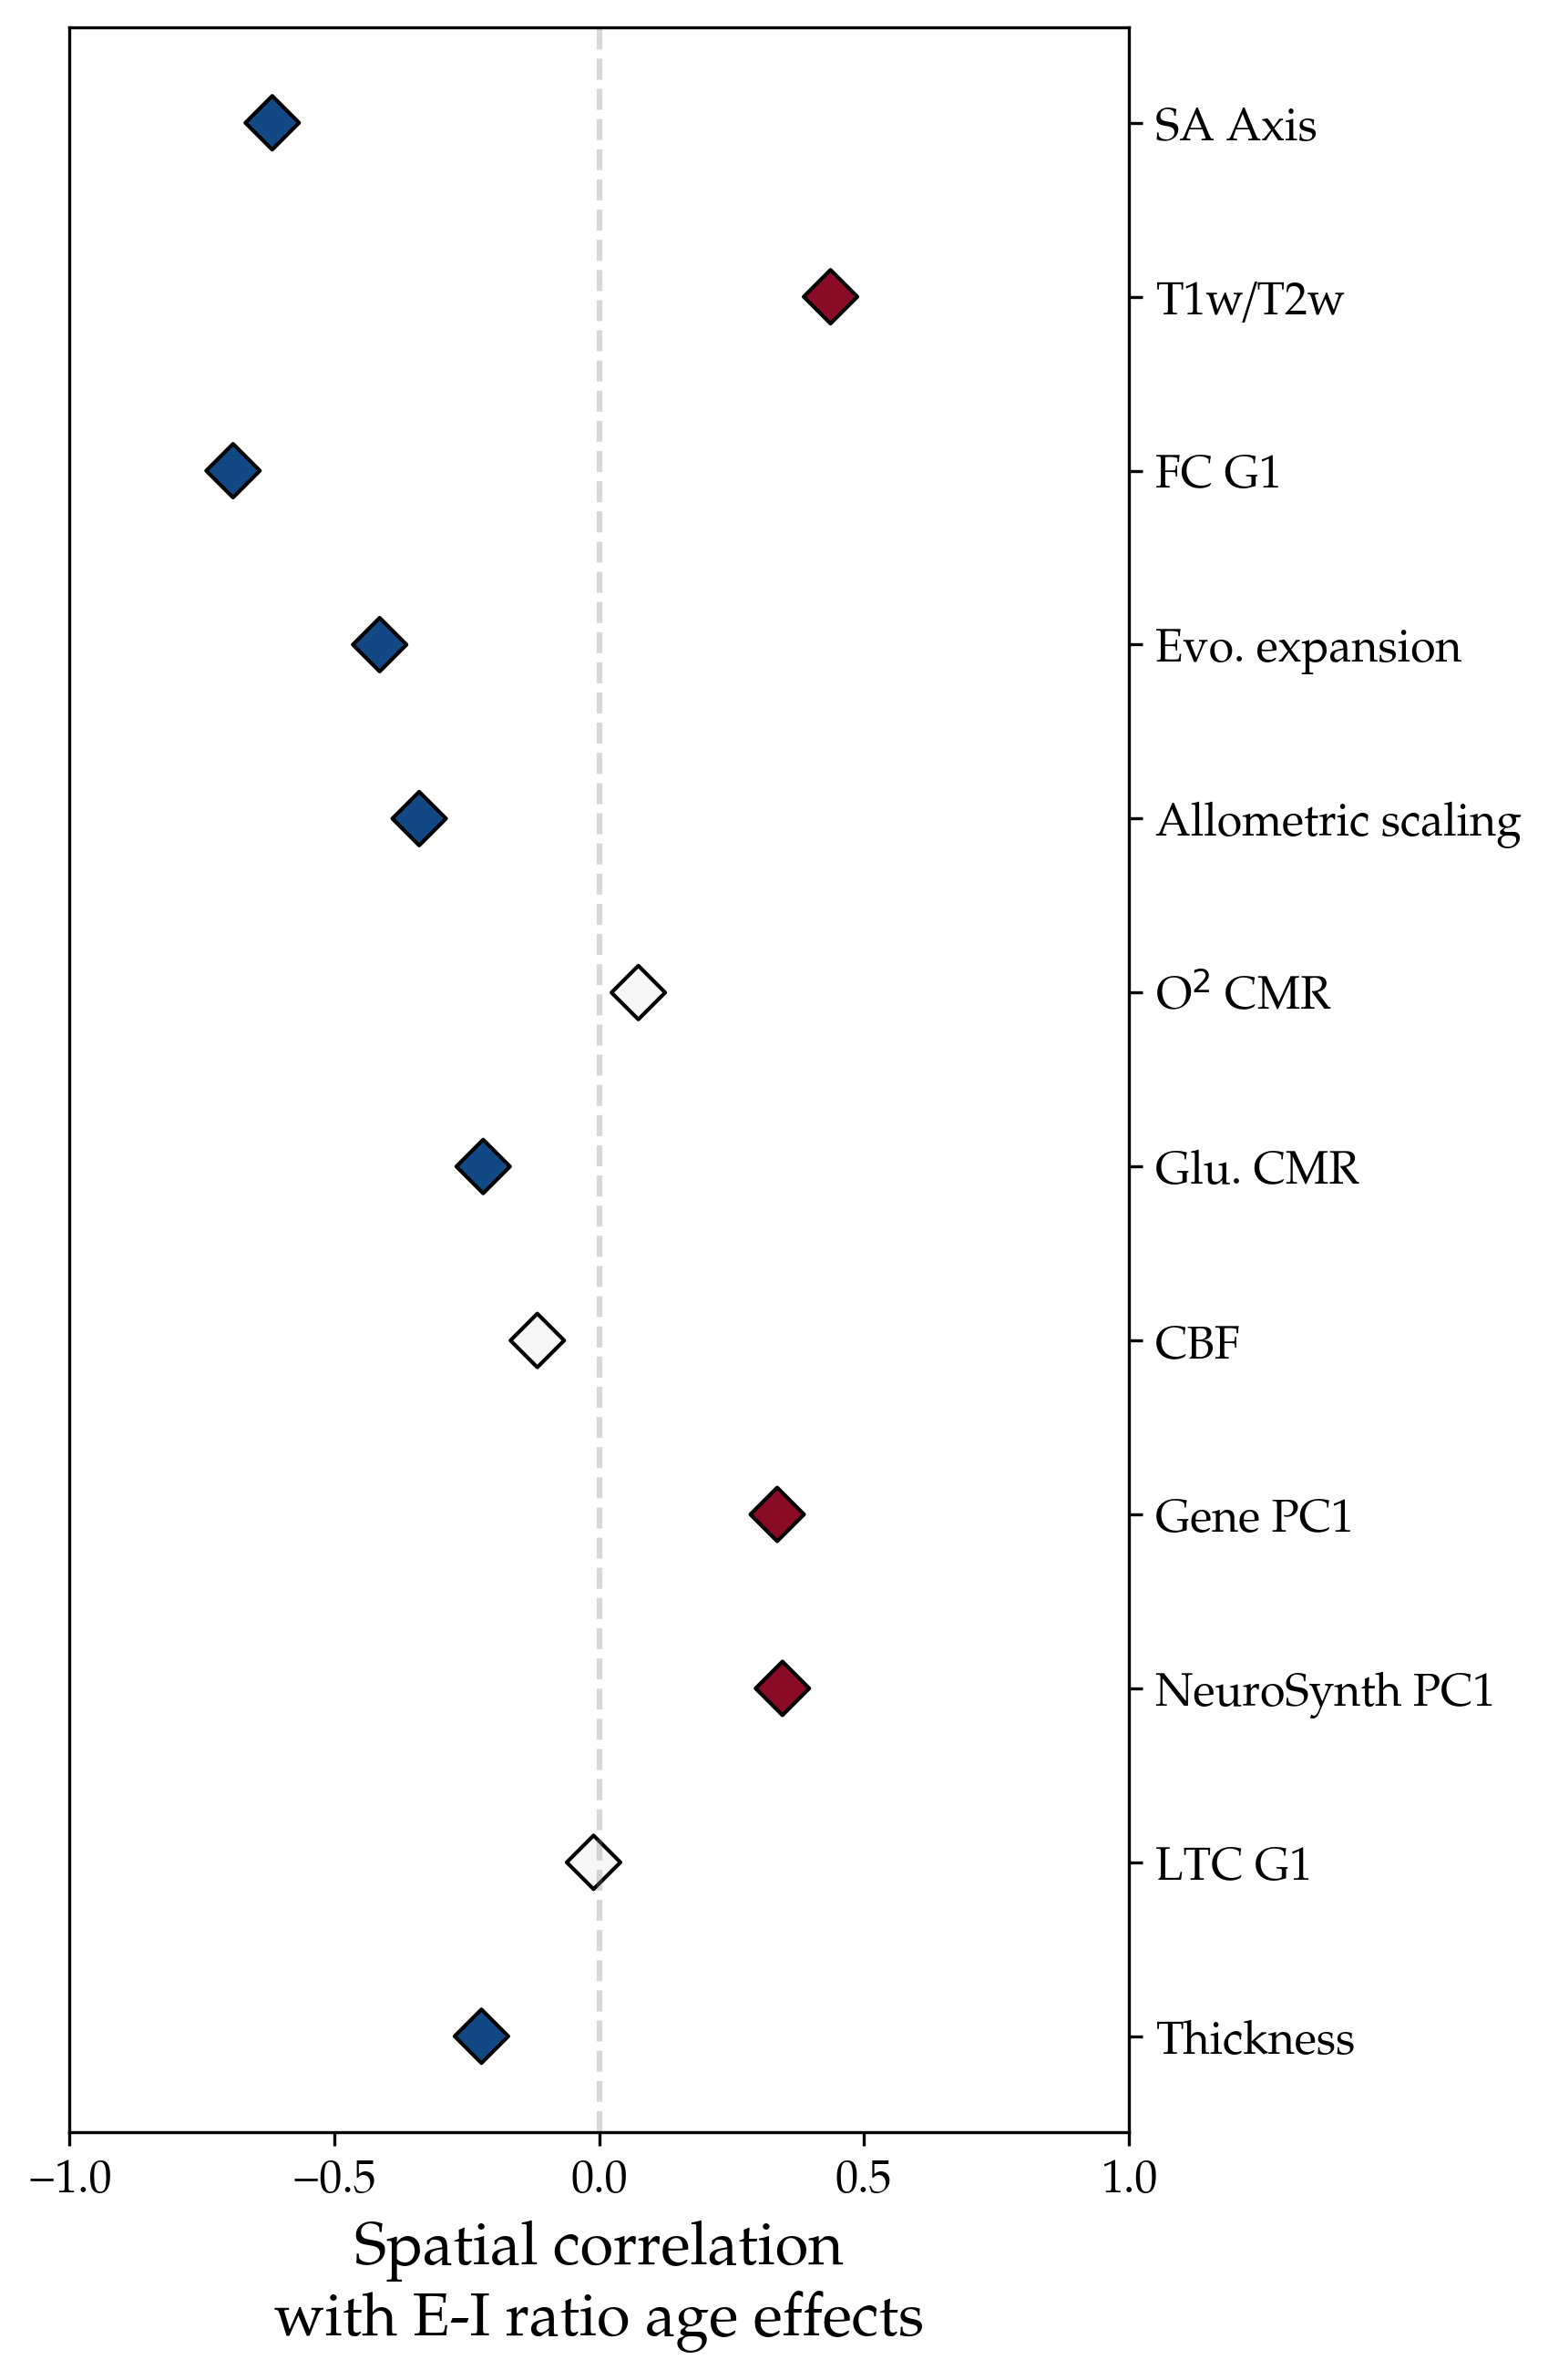

In [7]:
fig, ax = plt.subplots(figsize=(5, 10))
c_array = r_aget_maps.copy()
c_array[p_aget_maps >= 0.05] = 0
c_array[c_array < 0] = -0.9
c_array[c_array > 0] = 0.9
ax.scatter(
    y=r_aget_maps.columns,
    x=r_aget_maps.T.values[:, 0],
    c=c_array.T.values[:, 0],
    cmap="RdBu_r",
    s=100,
    marker="D",
    edgecolors="black",
    vmin=-1,
    vmax=1,
)
ax.set_ylim(ax.get_ylim()[::-1]) 
ax.yaxis.tick_right()
ax.set_xlim([-1, 1])
ax.set_xlabel(
    "Spatial correlation\nwith E-I ratio age effects", fontsize=16
)
ax.set_yticklabels(map_names, rotation=0)
ax.axvline(0, linestyle="--", c="grey", alpha=0.3)

## B. Association with canonical resting state networks

Plot association:

Text(273.91666666666663, 0.5, 'Effect of age on E-I ratio')

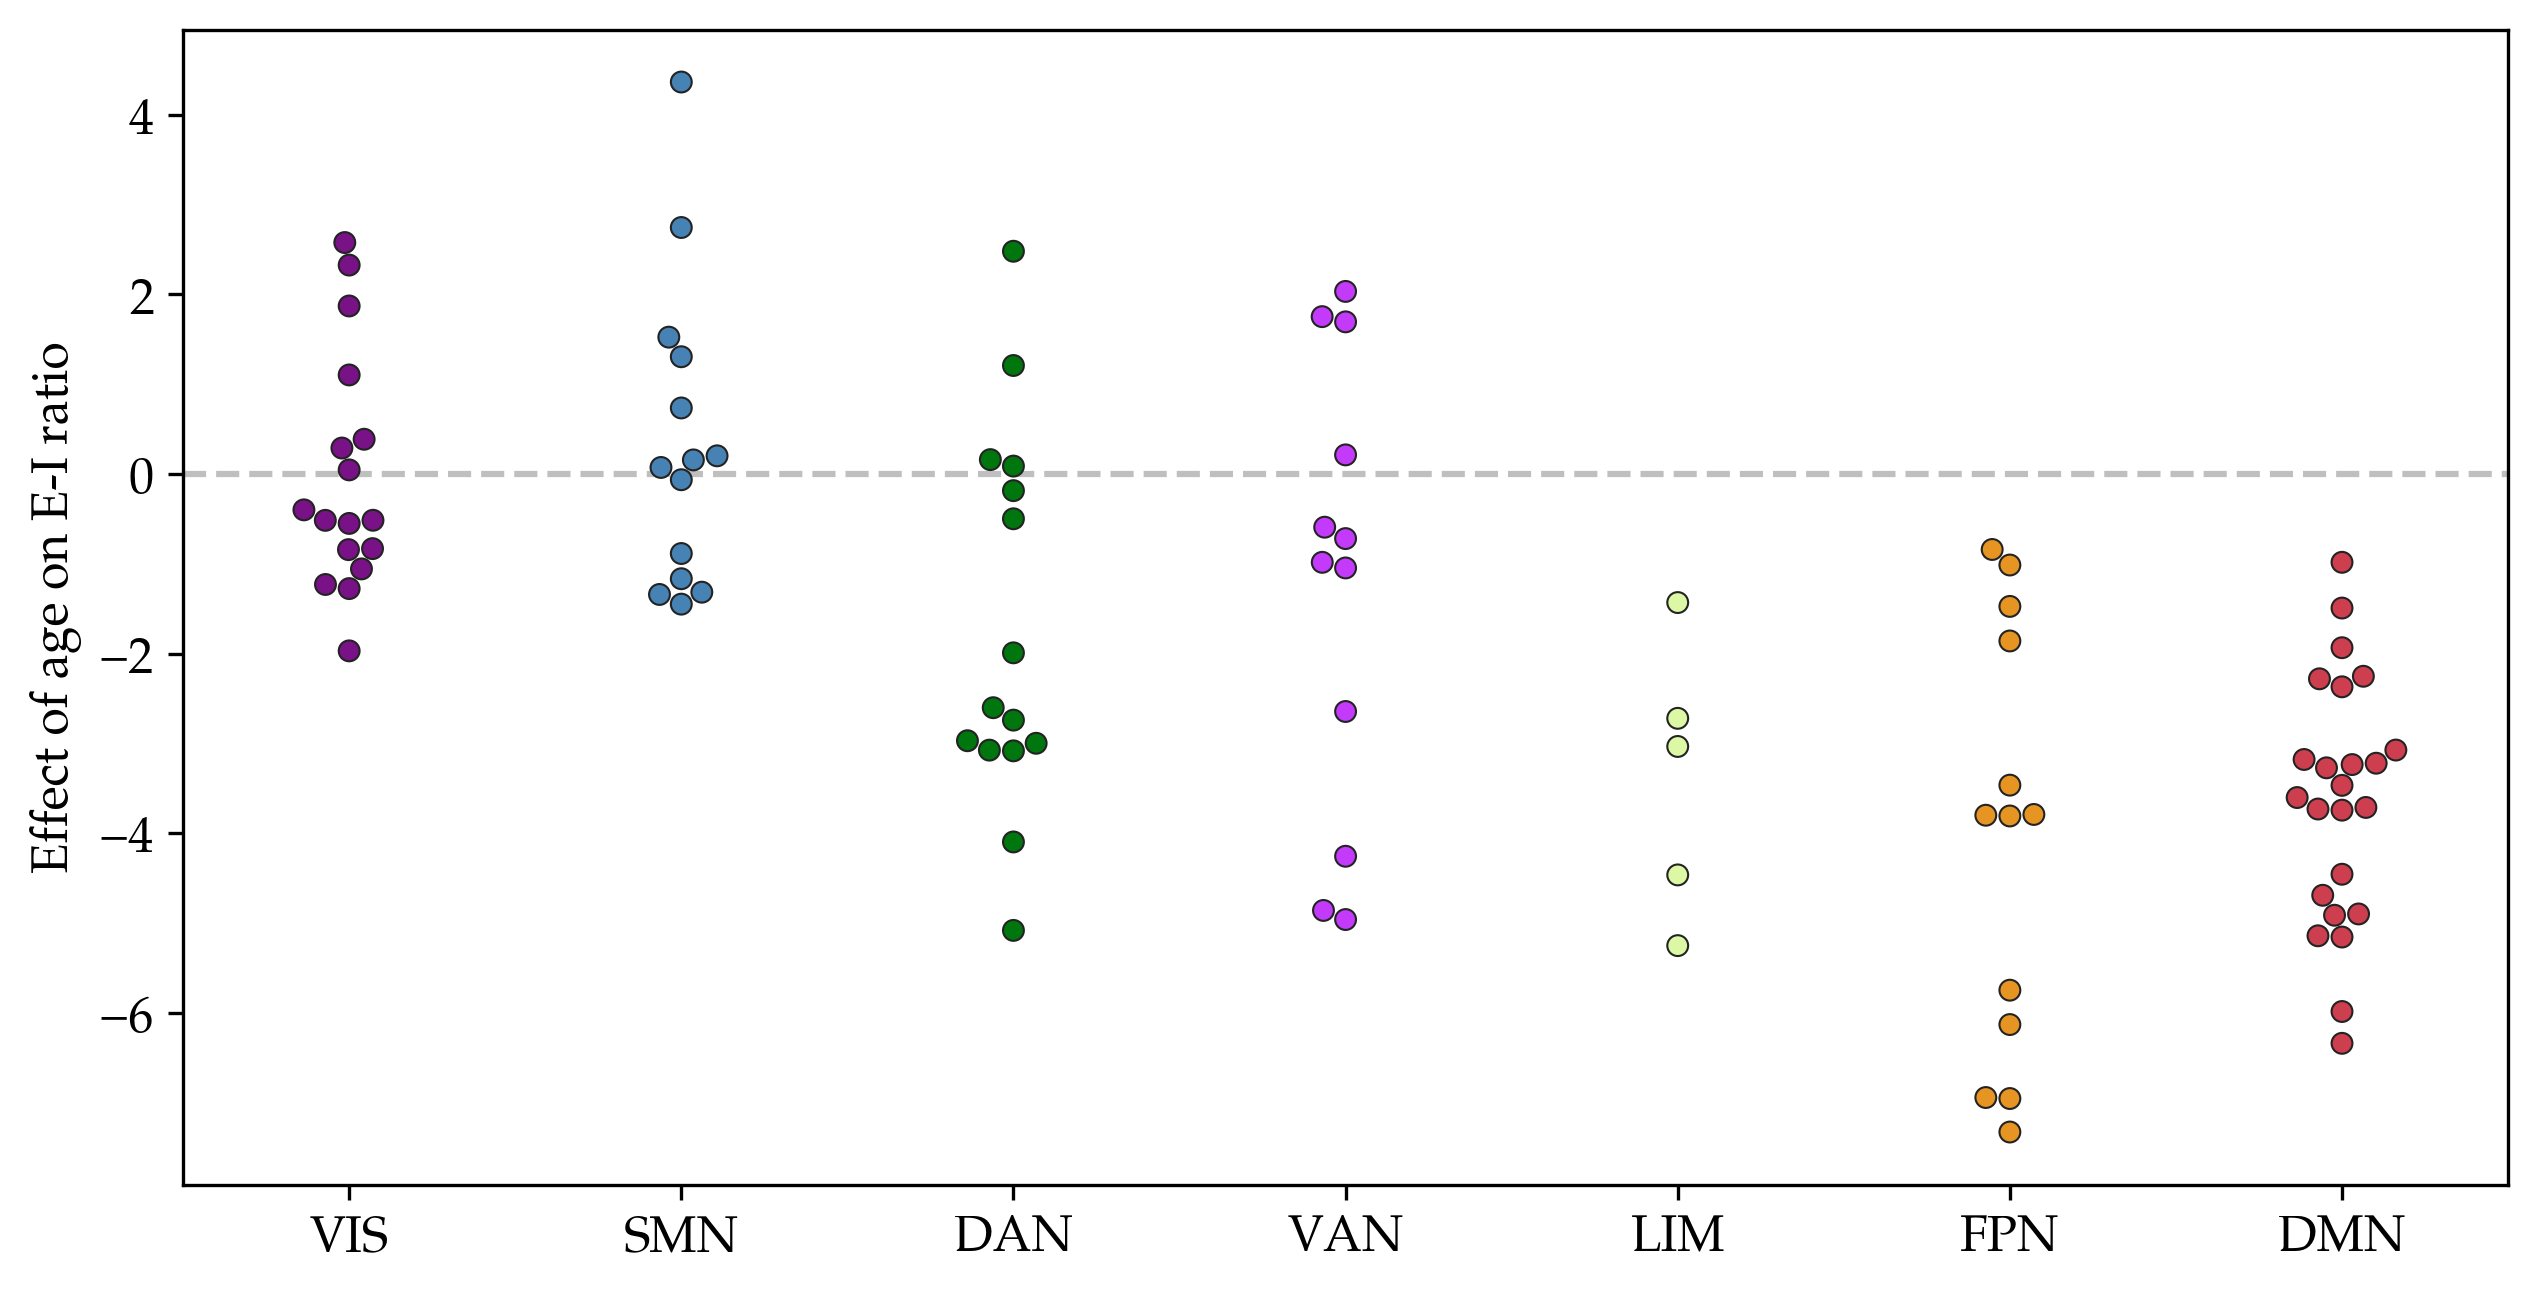

In [8]:
# define Yeo network of each parcel based on its name
yeo = list(map(lambda s: s.split("_")[2], parcels))

yeo_colors = [
    (0.470588, 0.0705882, 0.52549),
    (0.27451, 0.509804, 0.705882),
    (0.0, 0.462745, 0.054902),
    (0.768627, 0.227451, 0.980392),
    (0.862745, 0.972549, 0.643137),
    (0.901961, 0.580392, 0.133333),
    (0.803922, 0.243137, 0.305882),
]

fig, ax = plt.subplots(figsize=(10, 5))
ax.axhline(0, linestyle="--", color="grey", alpha=0.5)
sns.swarmplot(x=yeo, y=stats_age_pnc["t"], palette=yeo_colors, ax=ax, linewidth=0.5)
ax.set_xticklabels(["VIS", "SMN", "DAN", "VAN", "LIM", "FPN", "DMN"])
ax.set_xlabel("")
ax.set_ylabel("Effect of age on E-I ratio")

Plot map:

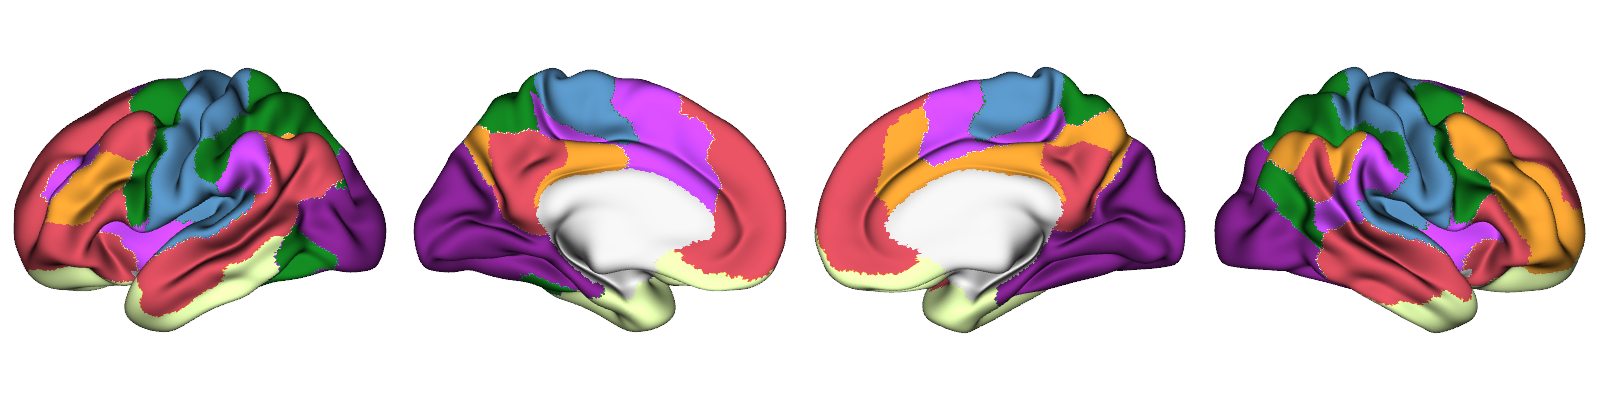

In [9]:
yeo_cmap = LinearSegmentedColormap.from_list("yeo", yeo_colors, 7)
plt.register_cmap("yeo", yeo_cmap)
yeo_cat = pd.Series(yeo, index=parcels, dtype="category")
yeo_cat = yeo_cat.cat.reorder_categories(
    ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]
)
yeo_surf = transform.deparcellate_surf(
    yeo_cat.cat.codes, "schaefer-100", space="fsaverage", concat=True
)
plot.plot_surface(
    yeo_surf,
    "fsaverage",
    mesh_kind="semi-inflated",
    cmap="yeo",
    cbar=False,
    layout_style="row",
)

Spin test:

In [10]:
yeo_categorical = (
    pd.Series(yeo, index=parcels)
    .astype("category")
    .cat.reorder_categories(
        ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]
    )
)
stats_yeo, p_yeo = stats.anova_spin(
    stats_age_pnc["t"], yeo_categorical, "schaefer-100", n_perm=1000
)
print(p_yeo["F"])

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.56it/s]

0.0


In [11]:
if p_yeo["F"] < 0.05:
    # bonferroni
    alpha = 0.05 / (p_yeo.shape[0] - 1)
    print(p_yeo[p_yeo < alpha])
    print(stats_yeo[p_yeo < alpha])

F                   0.000
Vis-Limbic          0.000
Vis-Cont            0.000
Vis-Default         0.000
SomMot-Limbic       0.002
SomMot-Cont         0.000
SomMot-Default      0.000
DorsAttn-Default    0.002
dtype: float64
F                   13.846545
Vis-Limbic           4.865062
Vis-Cont             6.013828
Vis-Default          8.415369
SomMot-Limbic        4.336134
SomMot-Cont          5.661853
SomMot-Default       7.906095
DorsAttn-Default     3.479831
dtype: float64


## C. Developmental specific expression analysis

Run CSEA tool: (Note: this sends an online request to the tool and will require internet connection + the CSEA tool website must be live)

In [12]:
nlog_dsea_res, p_spin, raw_dsea_res, top_genes, pls = stats.dsea_spin(
    stats_age_pnc[['t']], 'schaefer-100', 
    memmap='pnc_dsea_null_n-1000_seed-0.npy', n_perm=1000,
    seed=0, n_genes=500, fdr=True, pSI="0.05",
    mirror='http://doughertytools.wustl.edu/cgi-bin/seaBrainRegion.cgi',
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
continuing from permutation 1000


0it [00:00, ?it/s]


Positively-correlated genes:

In [13]:
print(*top_genes[0]["pos"], sep=" ")

MTIF3 MINDY2 GBP2 SLC2A11 PDZD7 RPS6KA2 LRP8 KIAA1551 ZNF565 PHF6 RAX2 IL17RC KCNIP2 ICE2 ANTXR2 EPHA7 KCNN4 BRAT1 CEP97 ZNF638 RWDD4 ANKRD18A ZNF417 SNHG17 PCNT FREM1 GK5 NRIP2 LOC100190986 ITGA11 LRRCC1 WSB1 WASHC2C SEPT14 SLC31A1 CEP350 BACE2 MATN3 GUSB LAMA4 PRR16 EPB41L1 SULT1A2 LOC283788 CTRL GOLGA2P5 PRAC1 MTTP PMS2P7 MPP5 ABTB2 MYO9B USH1C KCTD3 GUSBP3 LOC641746 ZDHHC20 ANKRD20A9P UNC13C ALS2CR12 PVR TBC1D8 UBE2O ZC3H11B RSPO2 MRPS11 KIAA1841 PMEPA1 GOLGA4 CAPN2 QRFPR CCT6A TMEM120B VAV3 LOC401320 TSTD3 CUX1 PECR TARSL2 TAP1 ZNF485 SUGT1P1 SEMA3A ATR OTUD7A ZNF234 HNRNPH1 ANXA5 ATP10A INTS6L RPS6KB2 TRAK2 MGST2 CCDC138 PXN CHST12 NEAT1 MICB HDAC4 CALCOCO2 SYT6 TRIP4 DSCAML1 PTPRD HNRNPCL1 KANK4 ACO1 MBD2 CBWD5 CDYL UTP14A ILDR1 ZNF644 PATJ CCDC88A MRPS5 MYLK NUTM2B-AS1 UPF1 CDR1 RAD51-AS1 ZEB2 PHACTR4 EDNRA PLEKHH2 HERC2P11 FRG1BP GFRA1 DPY19L2P4 CLCN4 TYW1B PTPN1 MLXIP ZZEF1 DDX24 TMEM41B EIF3E ACOT9 CLN3 C5orf24 MCM4 B3GLCT ANKRD13A SNX20 SPAG8 PIGC TRMT13 FAT3 LINC00367 TXLN

Their aggregate expression:

0 of 313 genes do not exist


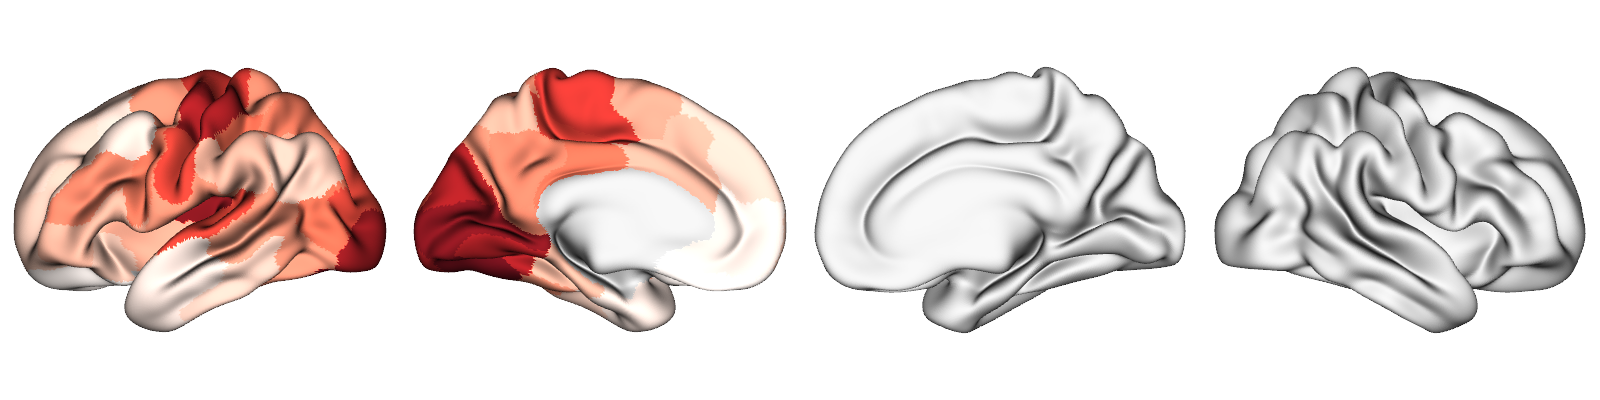

In [14]:
plot.plot_surface(
    transform.deparcellate_surf(
        datasets.load_aggregate_gene_expression(top_genes[0]["pos"], "schaefer-100"),
        "schaefer-100",
        space="fsaverage",
        concat=True,
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    cmap="Reds",
    cbar=False,
)

Negatively-correlated genes:

In [15]:
print(*top_genes[0]["neg"], sep=" ")

ABCC12 CDH8 NECTIN1 MYBPC1 CAPN12 SPACA9 ST6GALNAC5 COL10A1 TMIE GULP1 GYG2 RRP7BP CD53 CDC6 PKD2L1 CACNB2 CARTPT DNLZ PTPN9 SMIM24 ASS1 MUM1L1 HPGDS SERPINF1 OSCP1 FOXN3-AS1 HMGB3 LKAAEAR1 TMEM54 PGAM5 FZD9 SAMD14 KCNB2 TAF10 SLC39A4 TMEM160 TGFBR3L DGKZ NT5DC2 MRPL44 FAM174B NLE1 DENND1C OLFM3 TTPAL SH2D5 SAP30BP CDK20 MED4 CLPB PTP4A3 FLJ20021 CEP83 GGN ARF3 YBX2 TMEM8A SH3KBP1 VPS37D HES4 NIP7 CCKBR MAGIX FAM173A NEUROD6 VAMP2 CPNE8 HTR3B LINC01176 EFNB2 TMIGD3 SLC29A3 SURF4 TOR1A LOC105378853 LIMD2 PIK3CD SATL1 RCSD1 EXOSC4 SNX32 GDF11 TBPL1 SPRN THRB TMEM53 MEA1 LOC105374546 MAPK11 FIG4 OR14I1 MAPKAP1 GALNTL5 DDX20 MIR7-3HG BOP1 ITPKA TAMM41 FOXRED2 TFPT LY6E NOV AGRN SLC30A3 KIF17 EHBP1L1 NEK6 CRYM COL23A1 RITA1 TNFSF13B SEMA6B FREM3 BTRC POLA2 MARC1 POLR3K CBFA2T3 CACNG3 ZER1 HAMP PKP3 CTXN1 DRG2 MED8 UBE2MP1 ARMC10 ERH RTN4RL1 SERPINI2 TRAPPC5 ARFIP2 TM7SF2 C16orf87 KLK5 CLDND2 MCHR2 TRMT12 PCDH19 C11orf95 TTC9C BCAR3 GPNMB HSD11B1L FAM86B3P GIT1 FAM182B LHPP GRM8 AKIP1 SYNGR3

Their aggregate expression:

0 of 187 genes do not exist


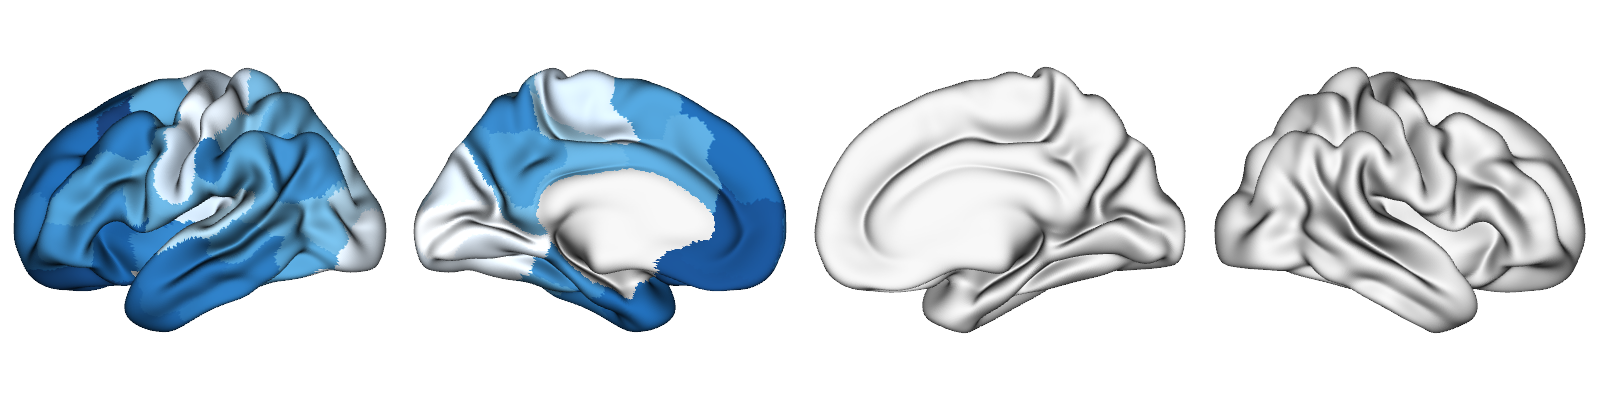

In [16]:
plot.plot_surface(
    transform.deparcellate_surf(
        datasets.load_aggregate_gene_expression(top_genes[0]["neg"], "schaefer-100"),
        "schaefer-100",
        space="fsaverage",
        concat=True,
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    cmap="Blues",
    cbar=False,
)

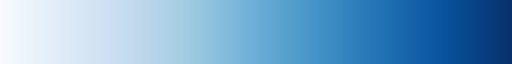

In [17]:
sns.color_palette('Blues', as_cmap=True)

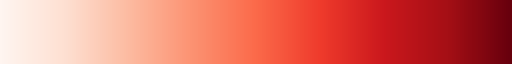

In [18]:
sns.color_palette('Reds', as_cmap=True)

Plot negative log p of Fischer exact tests, and indicate significance based on spin test p-values:

<Axes: ylabel='-log(p)'>

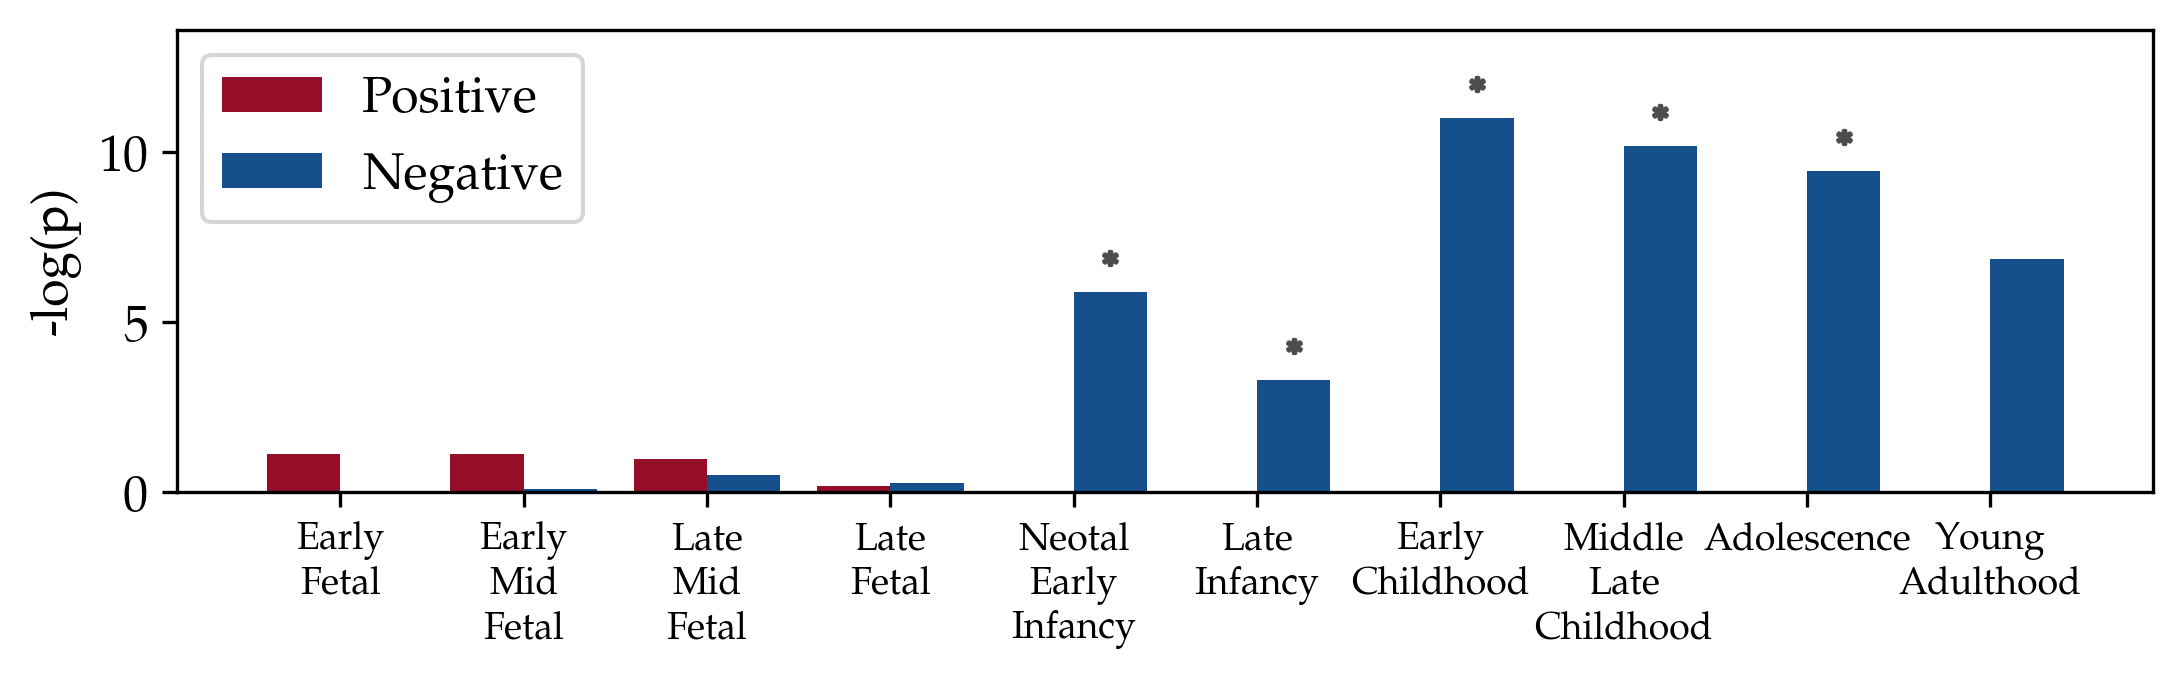

In [19]:
# FDR correction of spin p-values
_, p_fdr_spin = statsmodels.stats.multitest.fdrcorrection(p_spin)
p_fdr_spin = pd.Series(p_fdr_spin, index=p_spin.index)
# plot with significance based on p_fdr_spin < 0.05
sigs = {k: pd.Series(v) for k, v in (p_fdr_spin < 0.05).unstack().to_dict().items()}
stats.dsea_plot(nlog_dsea_res, sigs, colors={'Positive':red, 'Negative':blue})

# Figure S6. Multimodal maps of sensorimotor-association cortical axis

SAaxis


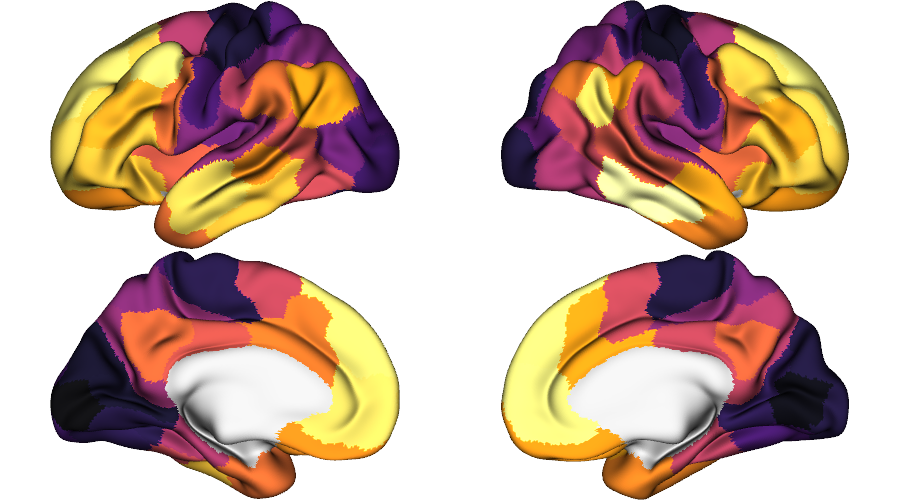

myelinmap


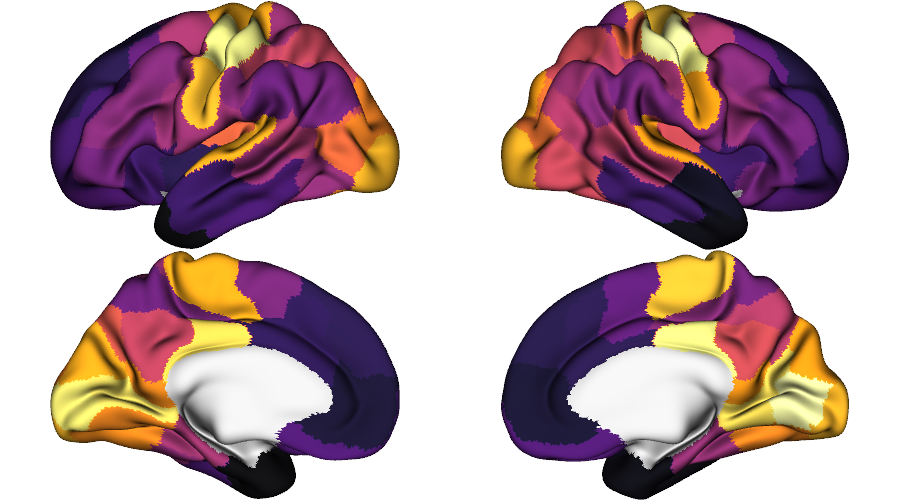

fcgradient01


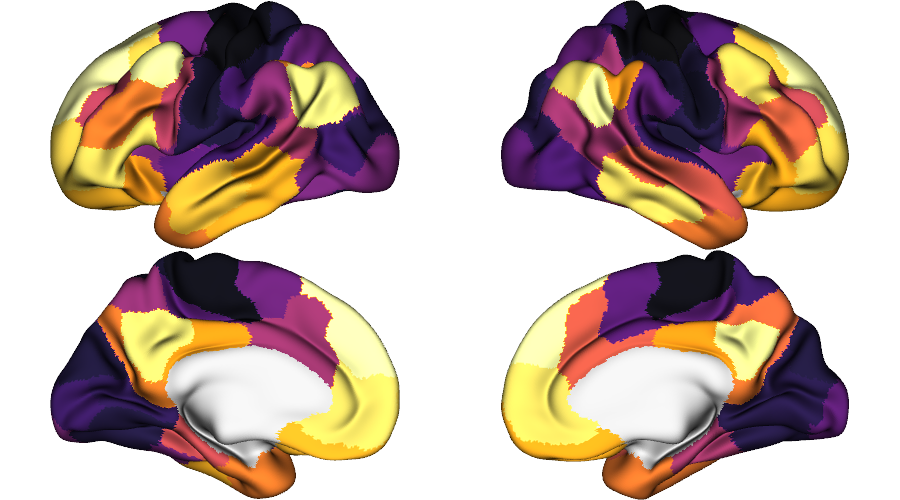

evoexp


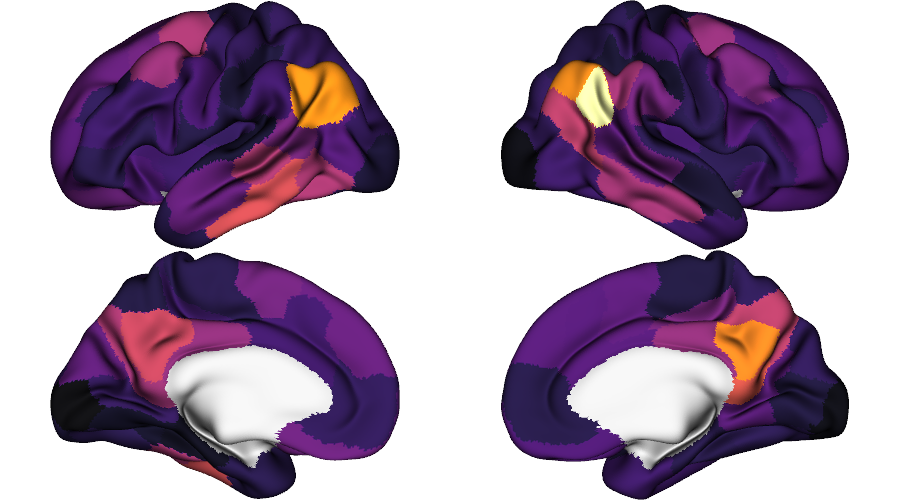

scalingpnc


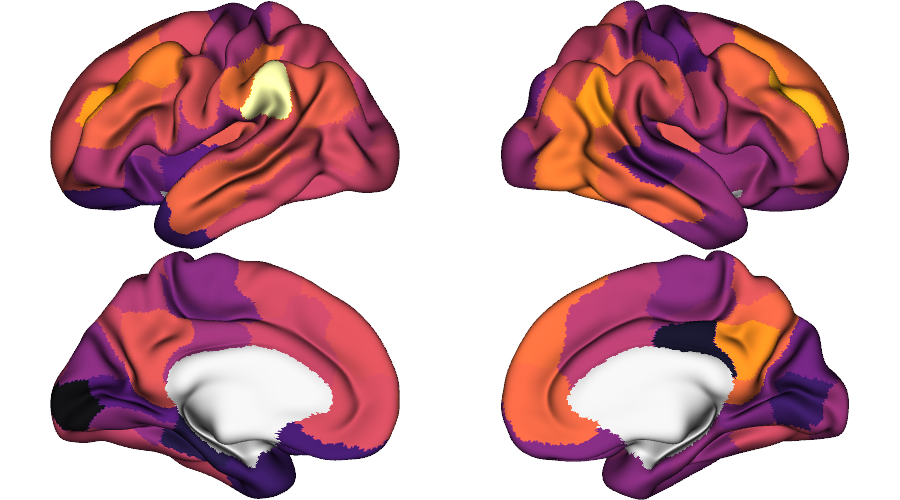

cmr02


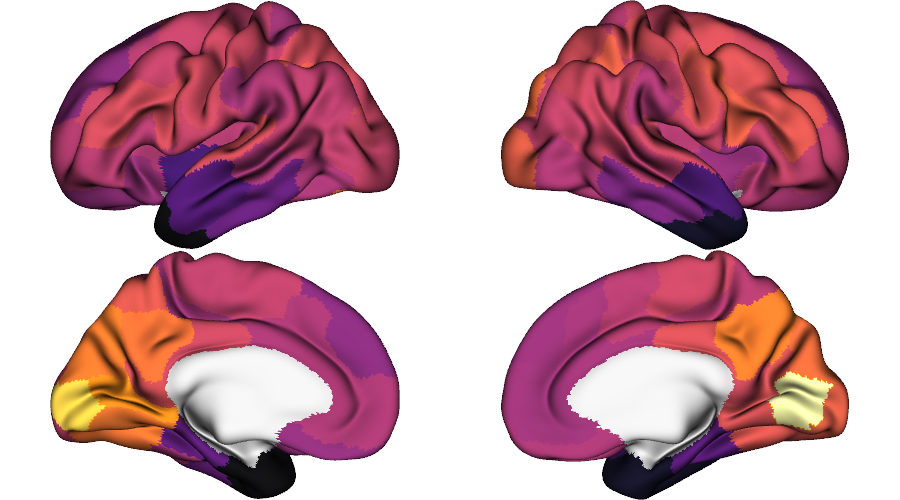

cmruglu


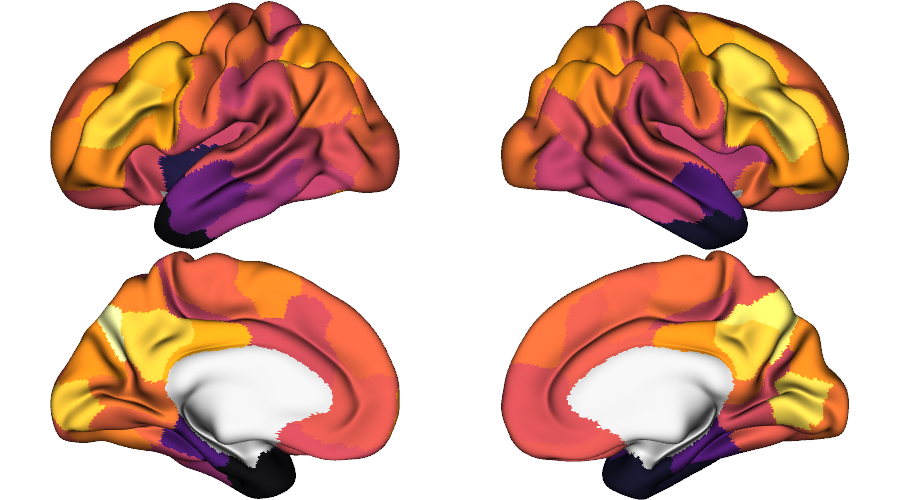

meancbf


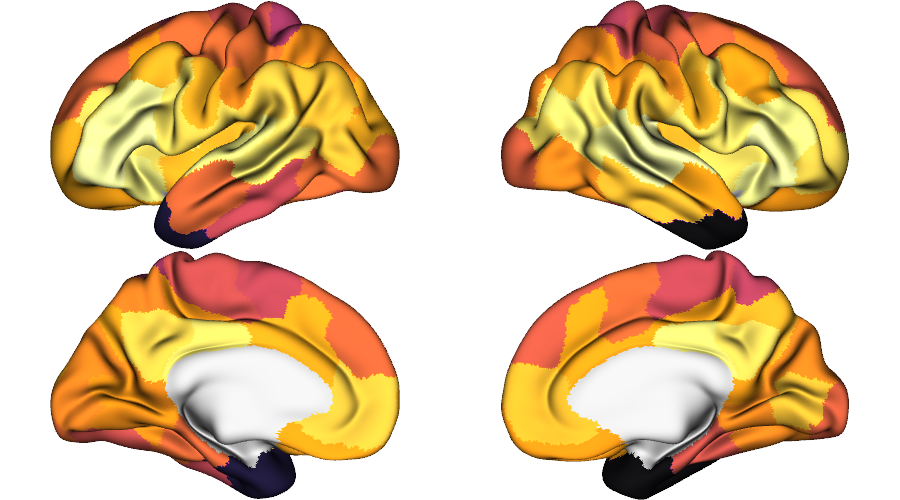

genepc1


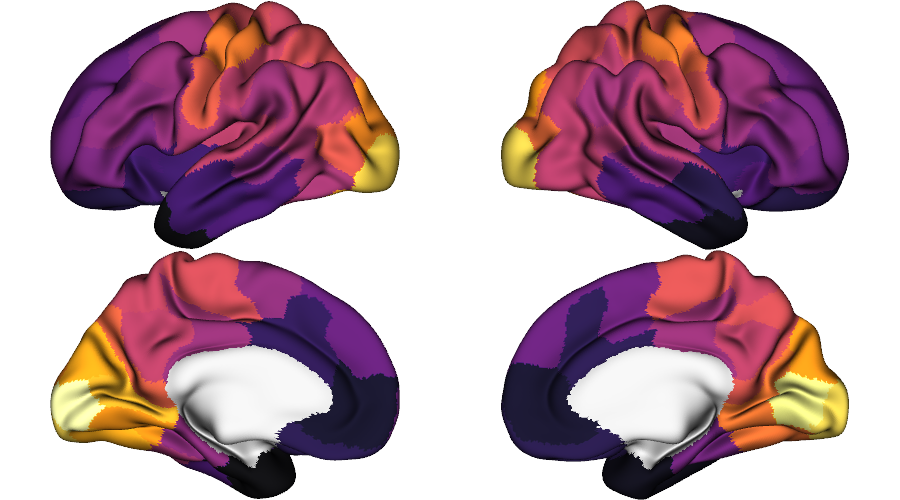

cogpc1


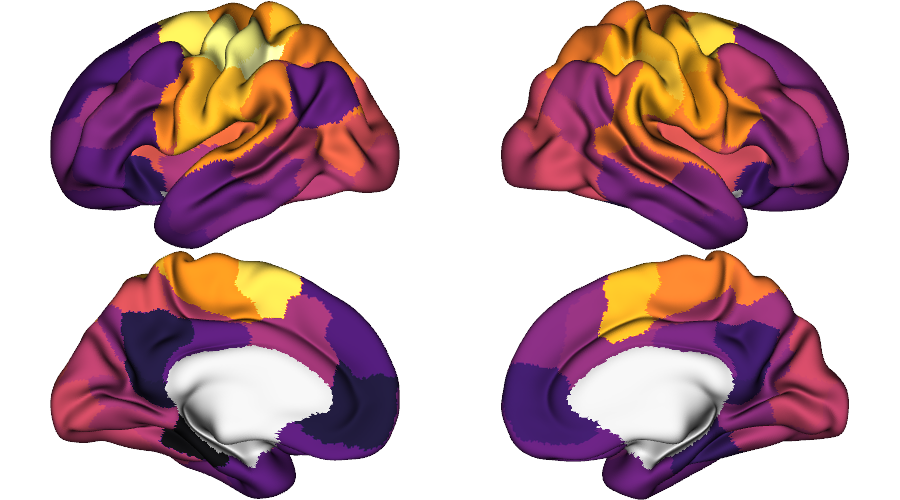

ltcg1


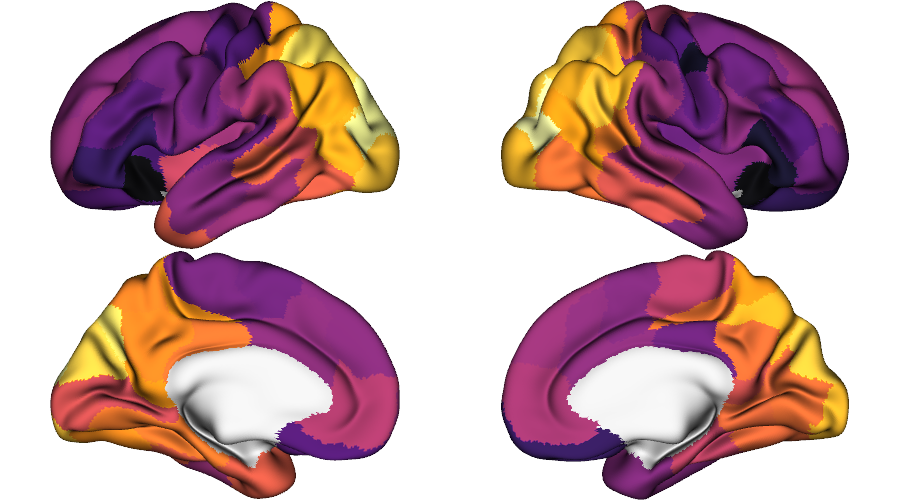

thickness


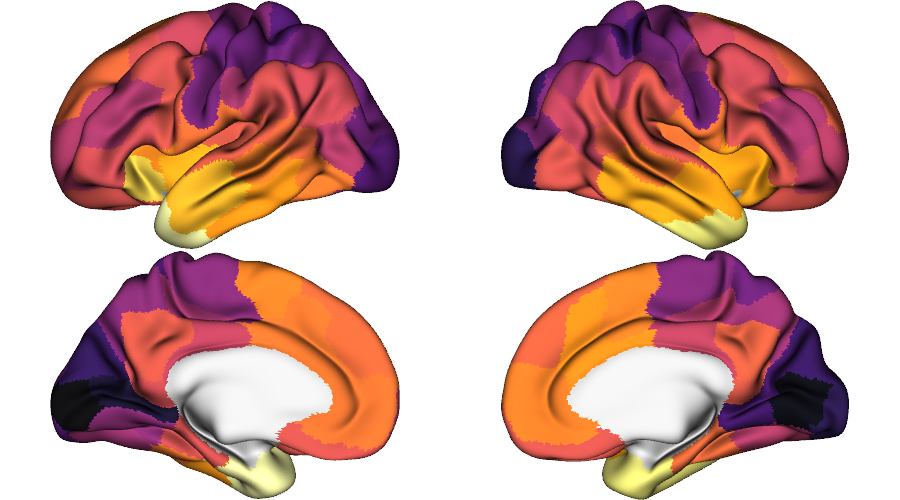

In [67]:
for col in maps.columns:
    print(col)
    display(
        plot.plot_surface(
            transform.deparcellate_surf(
                maps[col], "schaefer-100", concat=True, space="fsaverage"
            ),
            "fsaverage",
            mesh_kind="semi-inflated",
            cmap="inferno",
            cbar=False,
            layout_style="grid",
        )
    )

(-0.5, 0.5, 999.5, -0.5)

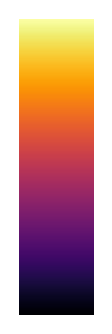

In [37]:
fig, ax = plt.subplots(figsize=(0.5, 2))
gradient = [[i] for i in range(1000)]
ax.imshow(gradient, aspect="auto", cmap="inferno_r")
ax.axis("off")

# Figure S7. Embedding of the excitation-inhibition developmental pattern in the IMAGEN dataset along the sensorimotor-association axis.

Load age effects map:

In [20]:
stats_age_imagen = pd.read_csv(
    "p_imagen_fc-ses_sc-FU2_runs-2_IE_age_stats.csv", index_col=0
)

## A. Spatial correlation with the sensorimotor-association axis

Spin test:

In [21]:
r_aget_maps, p_aget_maps, _ = stats.spin_test_parcellated(
    maps, stats_age_imagen[["t"]], "schaefer-100", n_perm=1000
)
print("Correlation coefficients\n", r_aget_maps, "\nSpin p-values\n", p_aget_maps)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficients
      SAaxis  myelinmap  fcgradient01   evoexp  scalingpnc     cmr02   cmruglu  \
t -0.607301   0.548002     -0.640855 -0.40201   -0.344884  0.343282 -0.001052   

    meancbf   genepc1    cogpc1     ltcg1  thickness  
t  0.035505  0.486835  0.347994 -0.059616  -0.340071   
Spin p-values
    SAaxis  myelinmap  fcgradient01  evoexp  scalingpnc  cmr02  cmruglu  \
t     0.0        0.0           0.0     0.0         0.0  0.001    0.991   

   meancbf  genepc1  cogpc1  ltcg1  thickness  
t    0.757      0.0   0.006  0.532      0.002  


Plot:

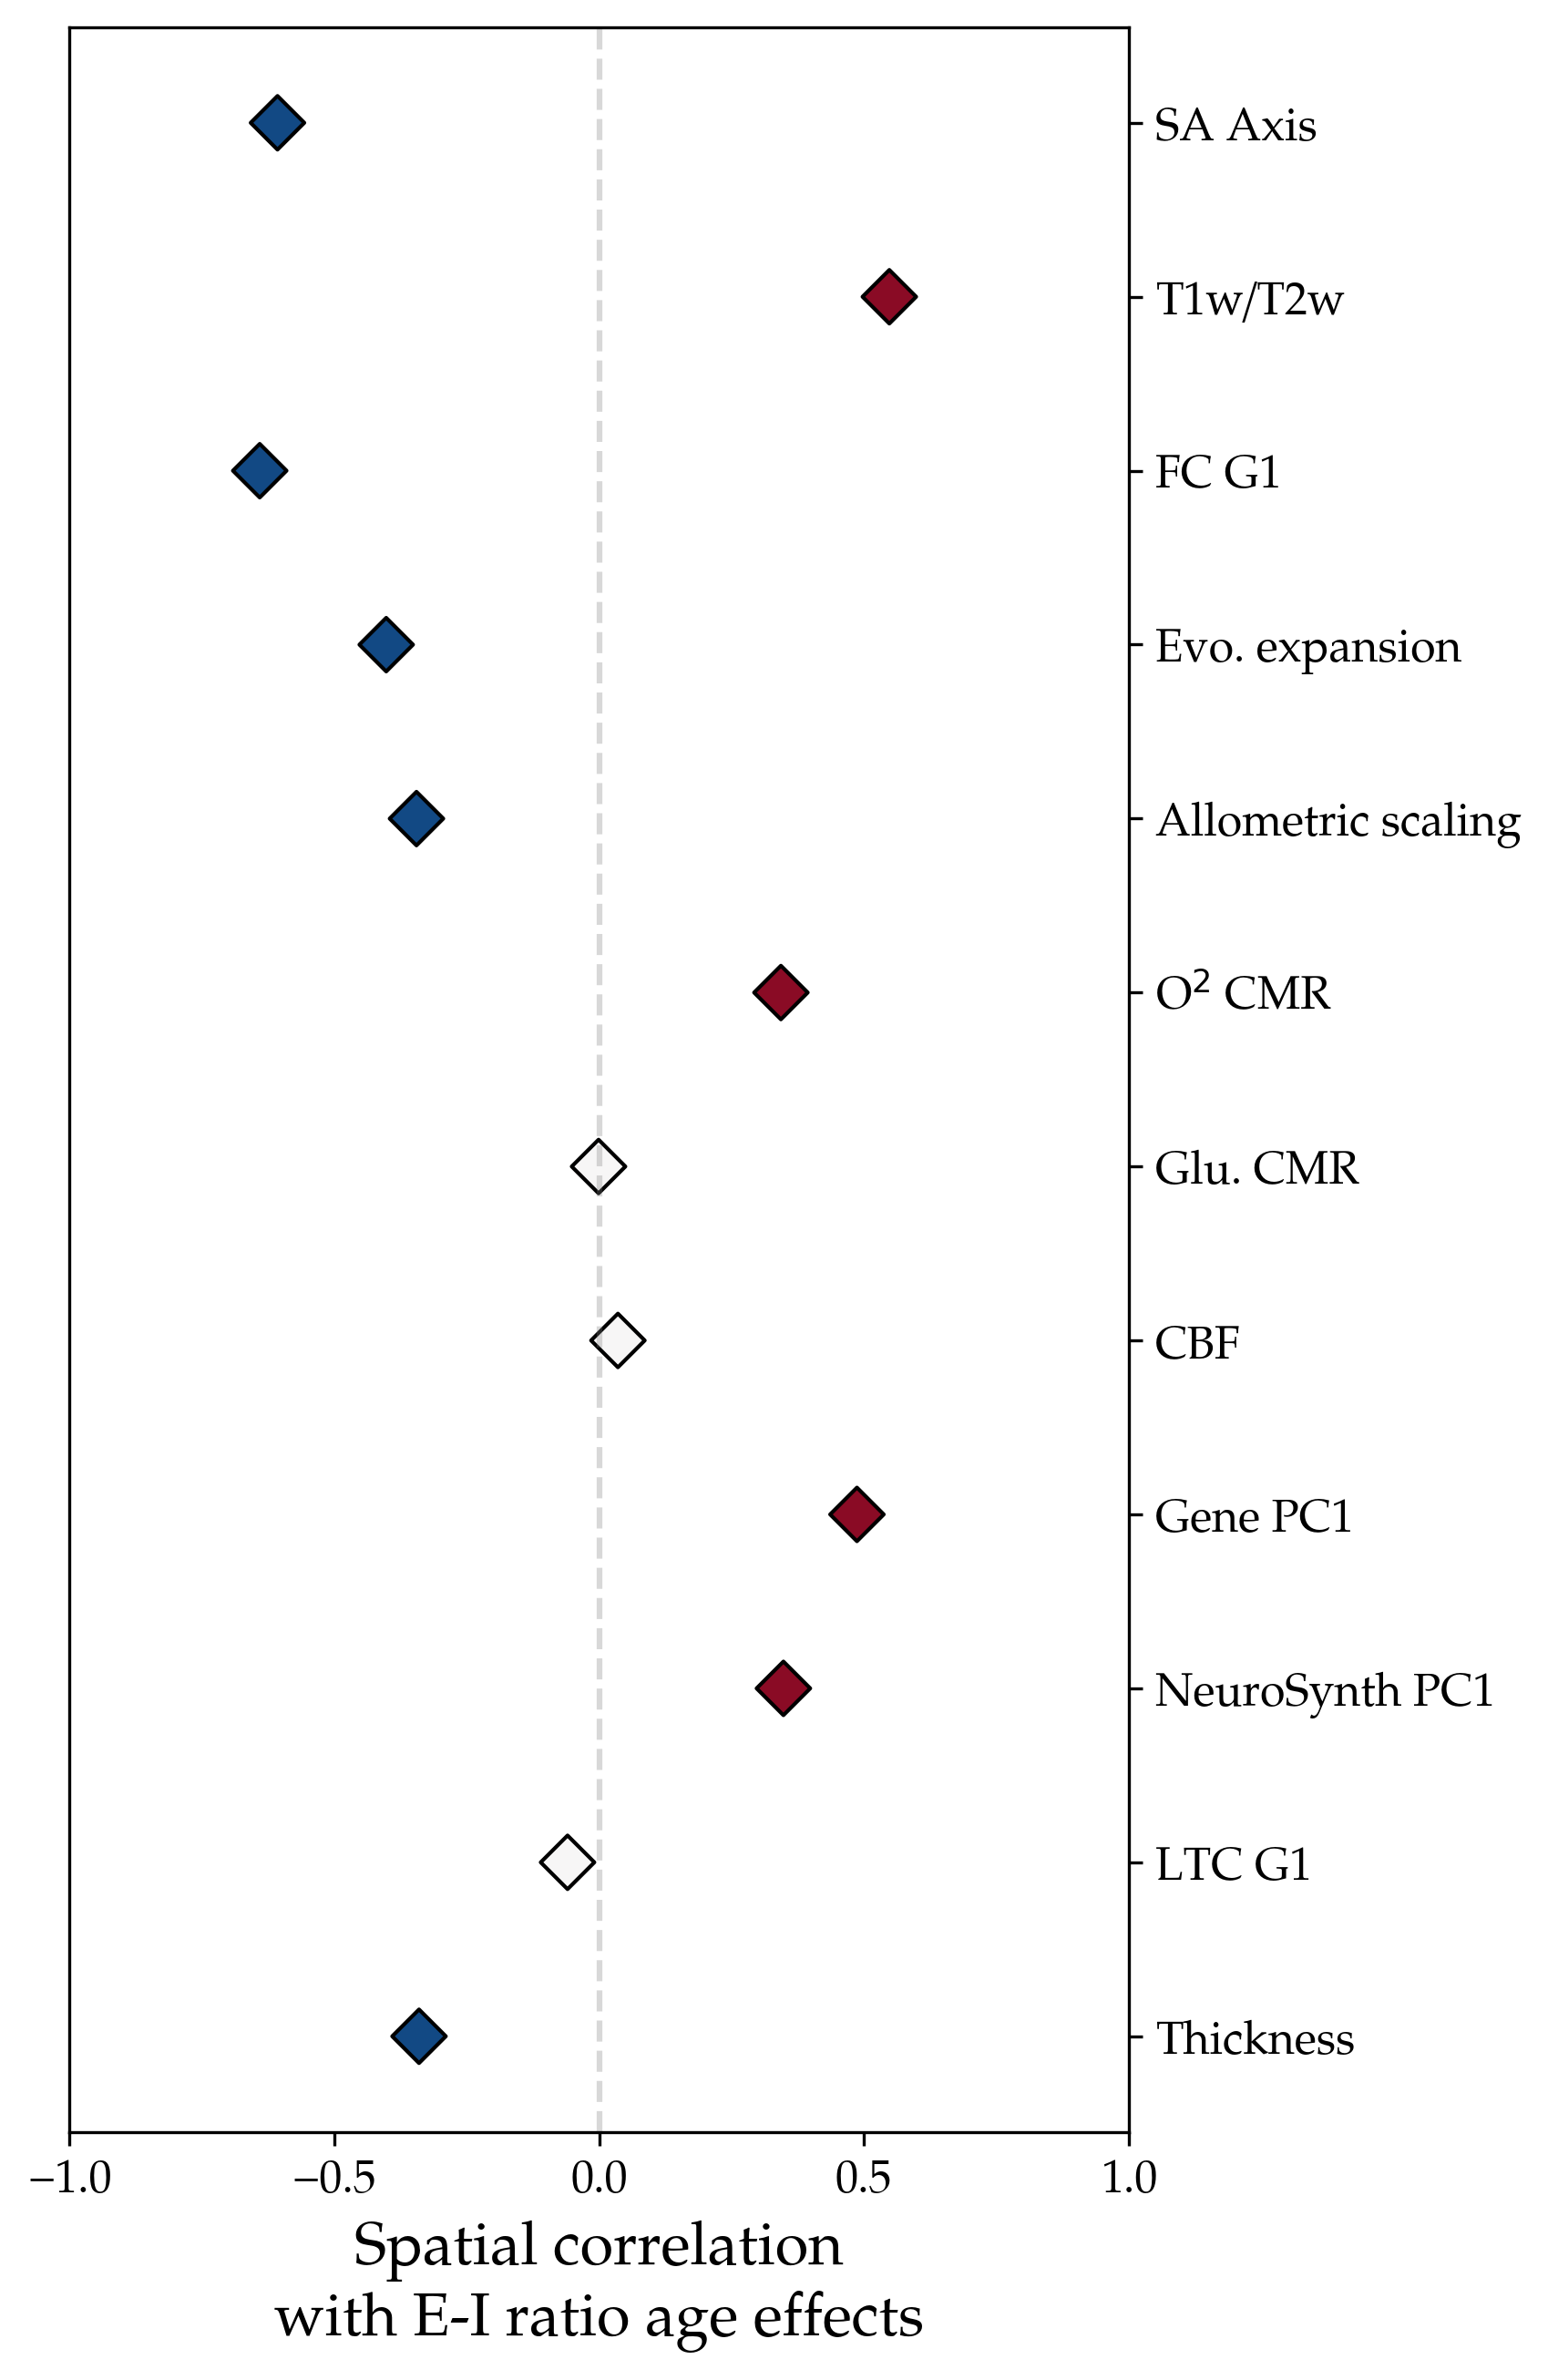

In [22]:
fig, ax = plt.subplots(figsize=(5, 10))
c_array = r_aget_maps.copy()
c_array[p_aget_maps >= 0.05] = 0
c_array[c_array < 0] = -0.9
c_array[c_array > 0] = 0.9
ax.scatter(
    y=r_aget_maps.columns,
    x=r_aget_maps.T.values[:, 0],
    # c=r_aget_maps.T.values[:, 0],
    c=c_array.T.values[:, 0],
    cmap="RdBu_r",
    s=100,
    marker="D",
    edgecolors="black",
    vmin=-1,
    vmax=1,
)
ax.set_ylim(ax.get_ylim()[::-1])  # put T1w/T2w at the top
ax.yaxis.tick_right()
ax.set_xlim([-1, 1])
ax.set_xlabel(
    "Spatial correlation\nwith E-I ratio age effects", fontsize=16
)
ax.set_yticklabels(map_names, rotation=0)
ax.axvline(0, linestyle="--", c="grey", alpha=0.3)

## B. Association with canonical resting state networks

Plot:

Text(273.91666666666663, 0.5, 'Longitudinal effect of age on E-I ratio')

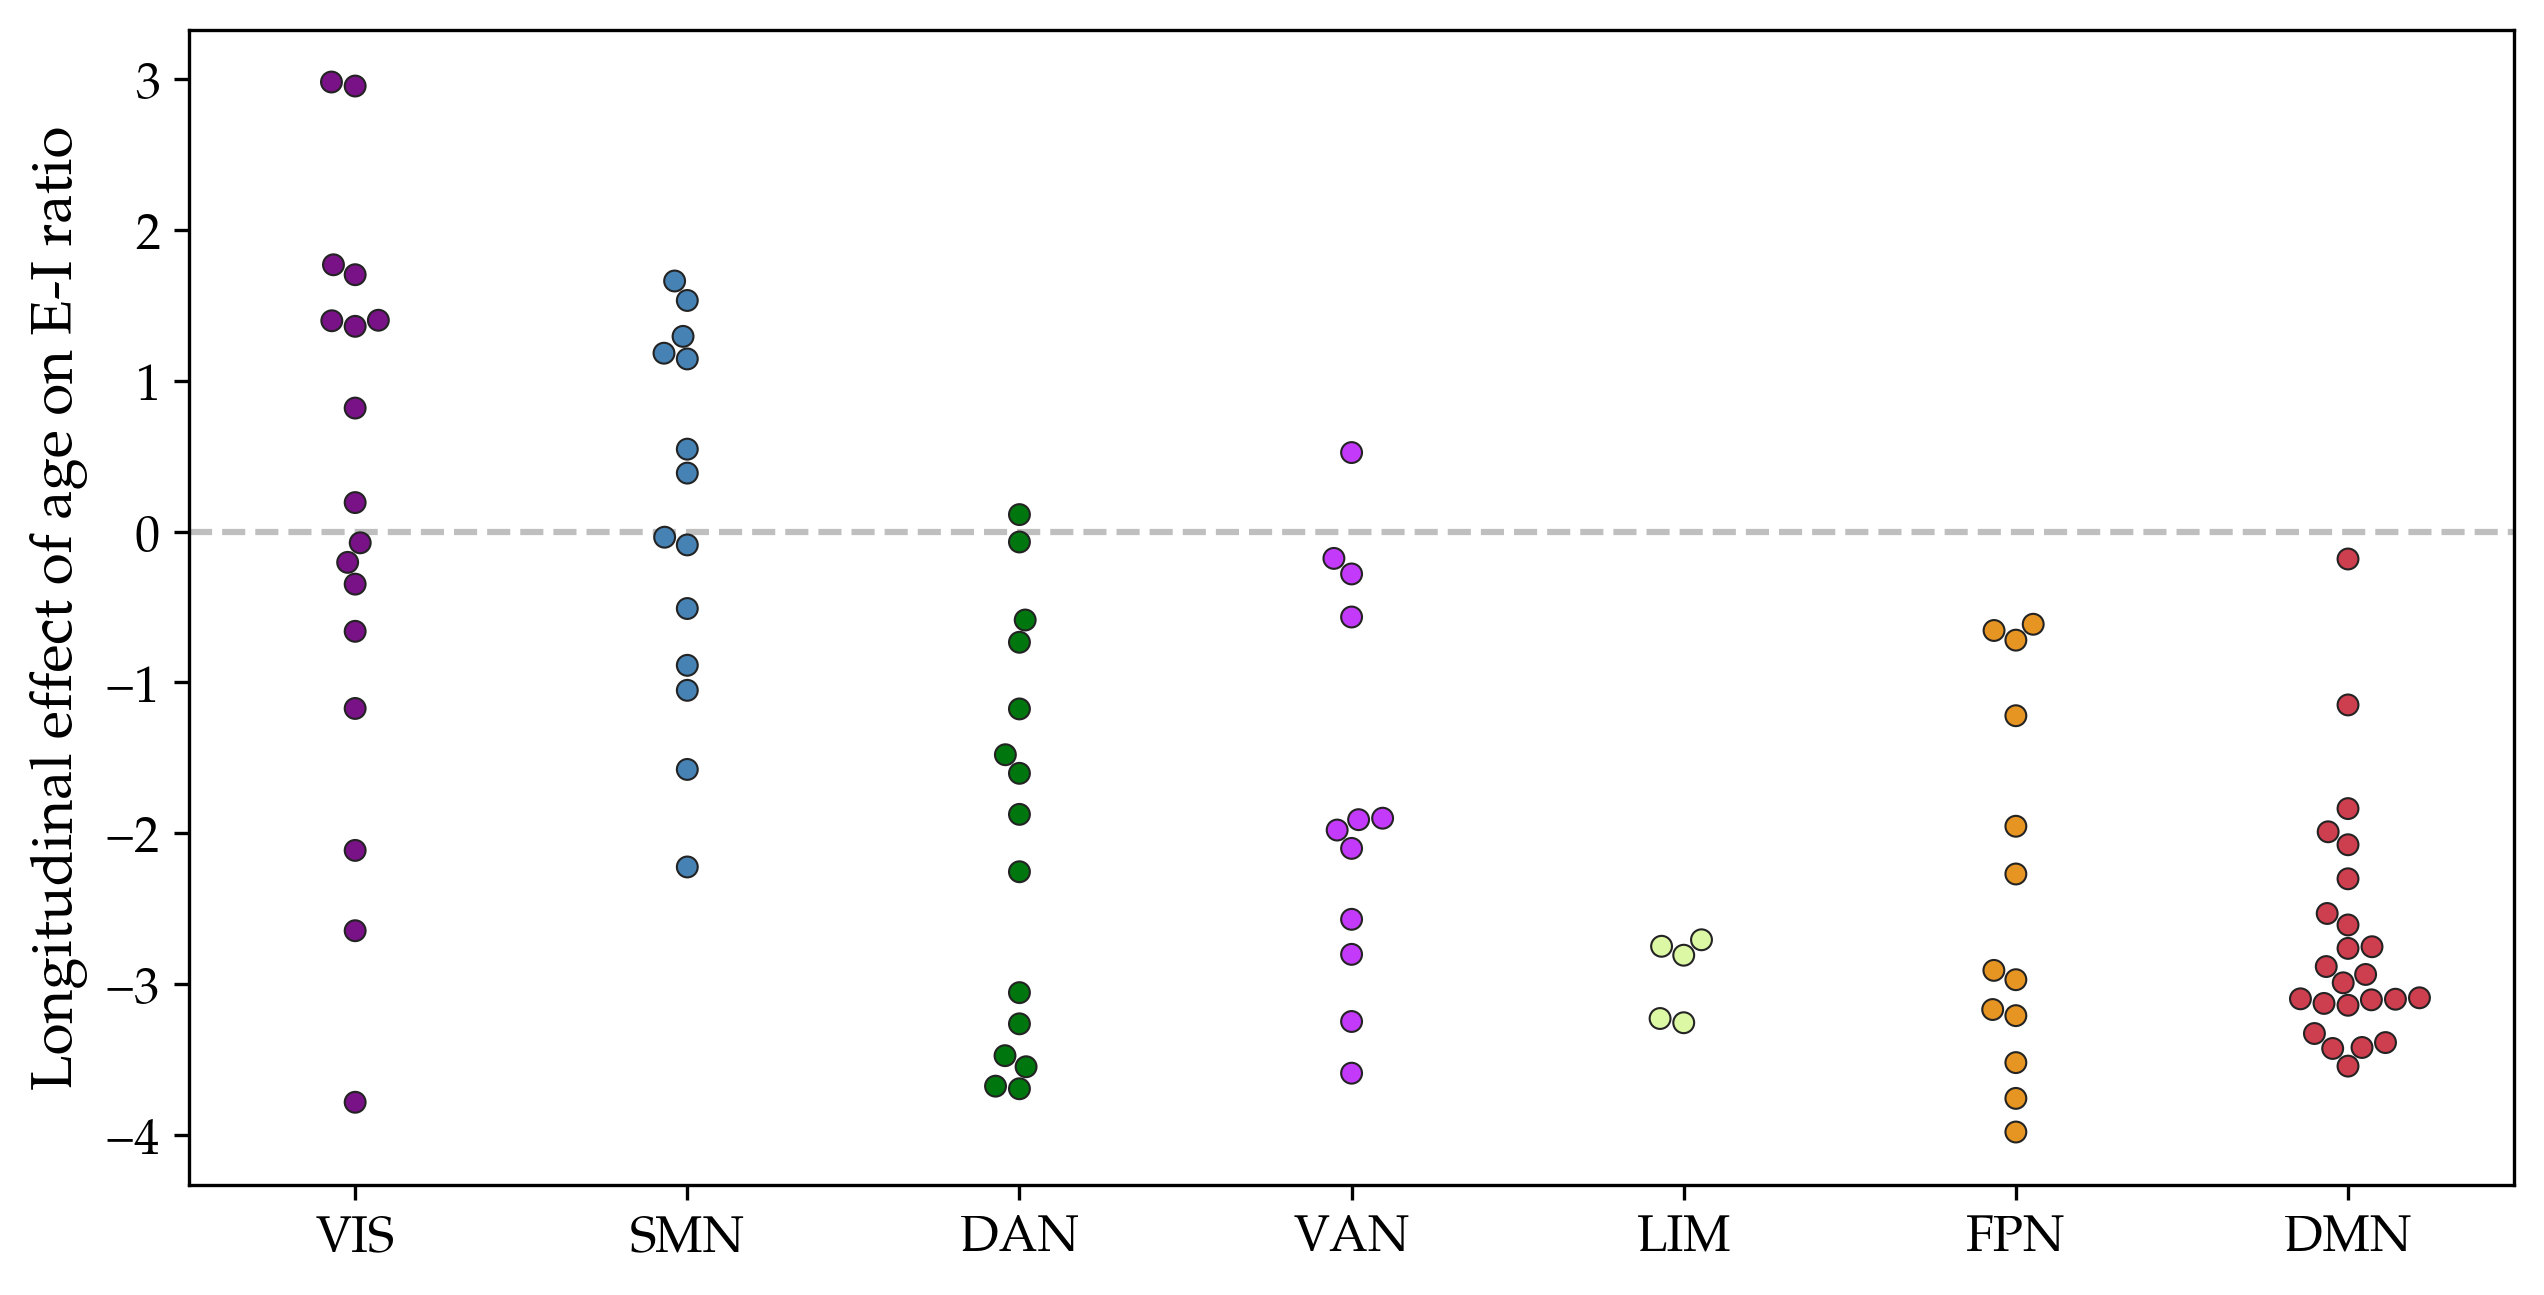

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axhline(0, linestyle="--", color="grey", alpha=0.5)
sns.swarmplot(x=yeo, y=stats_age_imagen["t"], palette=yeo_colors, ax=ax, linewidth=0.5)
ax.set_xticklabels(["VIS", "SMN", "DAN", "VAN", "LIM", "FPN", "DMN"])
ax.set_xlabel("")
ax.set_ylabel("Longitudinal effect of age on E-I ratio", fontsize=14)

Spin test:

In [24]:
stats_yeo, p_yeo = stats.anova_spin(
    stats_age_imagen["t"], yeo_categorical, "schaefer-100", n_perm=1000
)
print(p_yeo["F"])

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.39it/s]

0.0


In [25]:
if p_yeo["F"] < 0.05:
    # bonferroni
    alpha = 0.05 / (p_yeo.shape[0] - 1)
    print(p_yeo[p_yeo < alpha])
    print(stats_yeo[p_yeo < alpha])

F                     0.000
Vis-DorsAttn          0.002
Vis-Limbic            0.001
Vis-Default           0.000
SomMot-DorsAttn       0.000
SomMot-SalVentAttn    0.002
SomMot-Limbic         0.000
SomMot-Cont           0.000
SomMot-Default        0.000
dtype: float64
F                     14.571758
Vis-DorsAttn           3.792180
Vis-Limbic             3.665682
Vis-Default            6.775956
SomMot-DorsAttn        4.409423
SomMot-SalVentAttn     3.655717
SomMot-Limbic          5.435879
SomMot-Cont            5.256253
SomMot-Default         8.583460
dtype: float64


## C. Developmental specific expression analysis

Run CSEA tool: (Note: this sends an online request to the tool and will require internet connection + the CSEA tool website must be live)

In [26]:
nlog_dsea_res, p_spin, raw_dsea_res, top_genes, pls = stats.dsea_spin(
    stats_age_imagen[['t']], 'schaefer-100', 
    memmap='imagen_dsea_null_n-1000_seed-0.npy', n_perm=1000,
    seed=0, n_genes=500, fdr=True, pSI="0.05",
    mirror='http://doughertytools.wustl.edu/cgi-bin/seaBrainRegion.cgi',
)

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
continuing from permutation 1000


0it [00:00, ?it/s]


Positively-correlated genes:

In [27]:
print(*top_genes[0]["pos"], sep=" ")

AZGP1 KCNIP2 STON1 HDAC4 MLPH ITGA11 LAMA4 BHLHE22 B3GLCT B2M PENK IFNAR2 BACE2 MAP3K14 KIF23 UNC13C MATN3 EIF3E PCOLCE RARG HLA-DPB1 DIP2A NOP53 ANTXR2 MFSD2A WSB1 PAGR1 ABTB2 PATJ MRPS11 TSPAN9 EDNRA CUX1 RCL1 LOC440311 VAV3 SNW1 CEP97 CEACAM19 KIAA2013 CAMK2N2 ARIH2 HLA-J BLMH GLA MGST2 ITM2A MICB ACO1 ARID3B MRNIP MRPS18B COL19A1 CDK5RAP3 MAML3 SEL1L3 SYT6 PIK3IP1 BTN2A2 PCDH11Y TRIP4 TAP1 PRR16 DIDO1 PLAUR MAPKBP1 SPINK8 MYL12A MGC16025 UTRN SNHG17 PRDM8 GOLGA6L10 CCAR1 XKR8 MCM5 CBLB POMT1 DEGS2 LRRC23 ORAI2 PXN ZNF767P ECSCR ROCK1 VIPR2 LOC100190986 INTS6L PARP12 KCTD3 MLXIP VPS13C HLA-F PIGC TBL1Y HHIP-AS1 SCARF2 MAP3K3 LRP8 TUG1 KLHL36 LMO2 HLA-B MACROD1 HLA-C ATP10A COL13A1 CNTNAP5 LSM8 SMCHD1 MYO9B FBXL22 PCNT PLAGL1 ELK3 TANC1 TBL1X BBX MAN2A2 CRYGS MDC1 CEMIP LGR6 PKD1P6-NPIPP1 ARL5A PLK5 PCNA DENND6A SLC5A6 RBM23 CTTNBP2 ZIM2 GOLGA2P5 NXF1 ANKRD13A GUSB CCDC130 UIMC1 KCNN4 MRRF DCLRE1C USP3 DENND4C EEF1D OSGEPL1 NECAB3 FLRT3 TIMM23B HS3ST4 PHACTR4 QRFPR TEPSIN MTG2 RSPO2 

Their aggregate expression:

0 of 284 genes do not exist


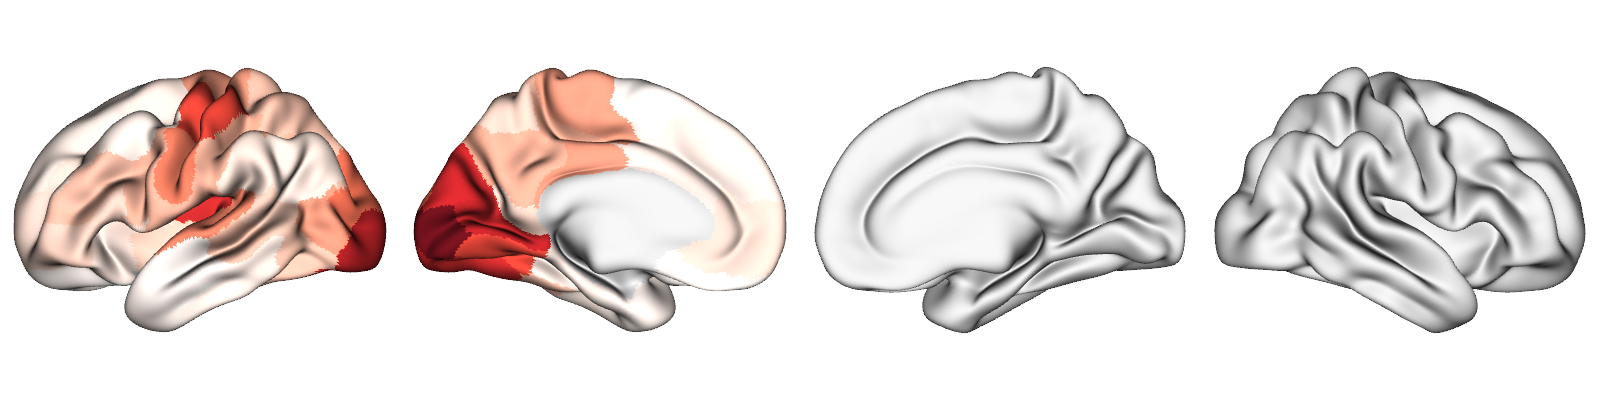

In [28]:
plot.plot_surface(
    transform.deparcellate_surf(
        datasets.load_aggregate_gene_expression(top_genes[0]["pos"], "schaefer-100"),
        "schaefer-100",
        space="fsaverage",
        concat=True,
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    cmap="Reds",
    cbar=False,
)

Negatively-correlated genes:

In [29]:
print(*top_genes[0]["neg"], sep=" ")

NEUROD6 MYBPC1 ST6GALNAC5 KCNB2 PKD2L1 GALNTL5 TRIM36 CACNB2 TMEM54 KCNV1 SAMD14 ASS1 EFNB2 GULP1 OR14I1 OLFM3 MUM1L1 PLXNA1 SH2D5 EGR3 CBLN4 MYBPC2 ABCC12 VSIG10L CASC10 KCNG3 CDH8 TP53BP2 CD83 CD53 YBX2 LINC01296 CHL1 SH3KBP1 PKP3 C2orf27A STAT6 TMIE GAP43 CAMK1G HTR1E DGKB PIK3CD SURF4 MRO ANKRD30B GRB14 FZD9 TXNRD3 LOC441666 CDC6 THRB MIR100HG SMIM24 SIDT1 CEP126 SV2B FOXN3-AS1 GRM8 STEAP1 LINC01197 SLC22A18 CCDC110 LOC440934 FRS3 MT3 ANO3 SRI PRDM16 PHLDA2 CCKBR NOV XYLT1 MIR99AHG DHRS4 CAPN12 CORT FAS CRYM NDST3 CDC42SE2 ARHGAP28 GPR22 KCNN2 STBD1 TTPAL CACNG3 RANBP3L NEK6 CA10 FAM213B OAF SIGIRR LRRC2 CCNYL1 CALHM1 SPACA9 BAALC SH2D2A CLEC4G DRAP1 BEND5 ASB6 WSB2 ZFP64 KIF17 DDIT4L TM7SF2 C9orf40 RASD1 BEGAIN HDAC9 AP1S1 LOC105374546 SNCG GGN GYG2 TFPT TAMM41 FBXL2 SHC3 TPST1 CARTPT NLE1 KIAA1549 MARC1 F12 NT5DC2 SATL1 GRASP LINC00982 COL11A1 LPL LINC00839 MRPL44 MIR7-3HG CHDH PITHD1 SNX10 HDGFL3 MAPK11 STK17A RNF182 SLC1A4 NT5DC3 HRH1 MAFK HES4 FREM3 ABCC6 GLRA3 PANX1 C2orf74 E

Their aggregate expression:

0 of 216 genes do not exist


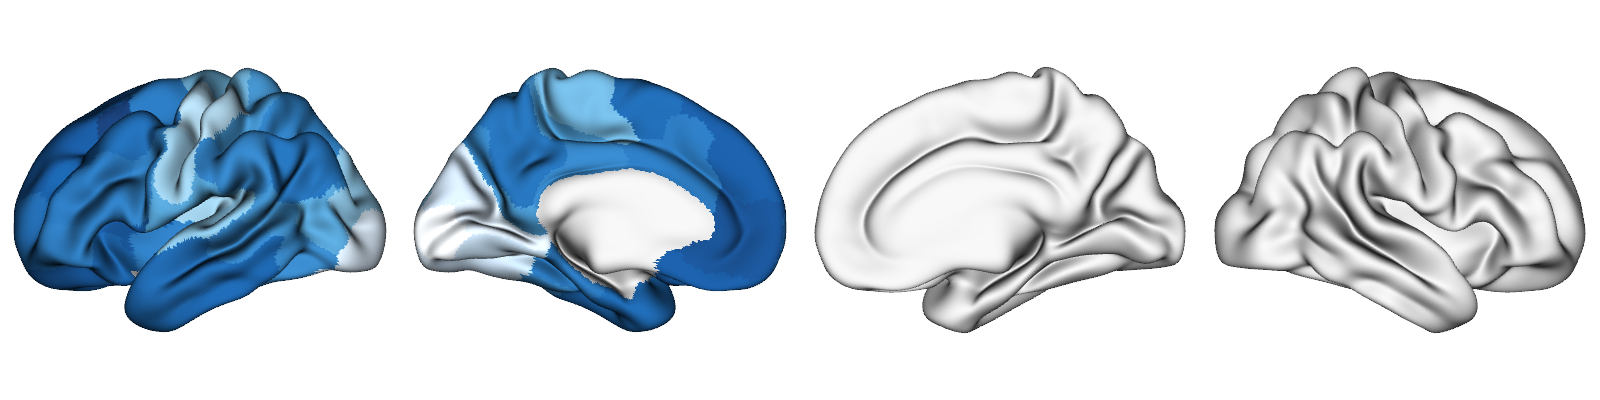

In [30]:
plot.plot_surface(
    transform.deparcellate_surf(
        datasets.load_aggregate_gene_expression(top_genes[0]["neg"], "schaefer-100"),
        "schaefer-100",
        space="fsaverage",
        concat=True,
    ),
    "fsaverage",
    mesh_kind="semi-inflated",
    cmap="Blues",
    cbar=False,
)

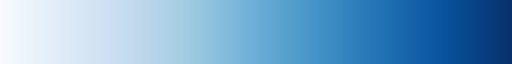

In [31]:
sns.color_palette('Blues', as_cmap=True)

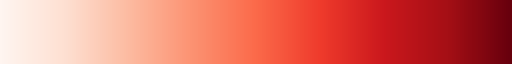

In [32]:
sns.color_palette('Reds', as_cmap=True)

Plot negative log p of Fischer exact tests, and indicate significance based on spin test p-values:

<Axes: ylabel='-log(p)'>

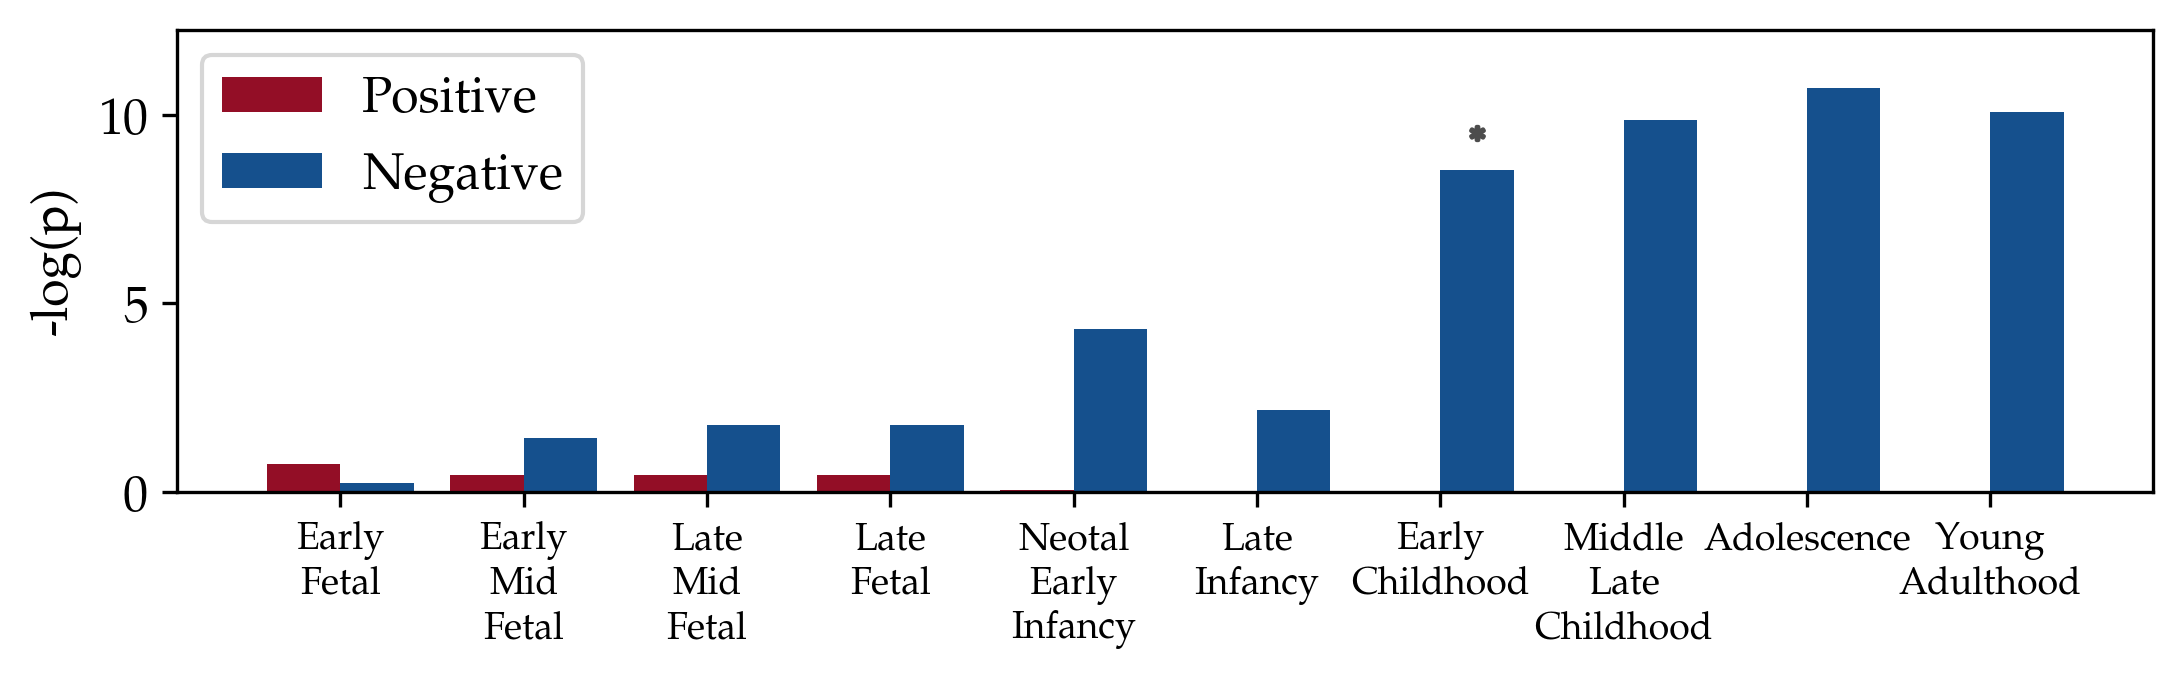

In [33]:
# FDR correction of spin p-values
_, p_fdr_spin = statsmodels.stats.multitest.fdrcorrection(p_spin)
p_fdr_spin = pd.Series(p_fdr_spin, index=p_spin.index)
# plot with significance based on p_fdr_spin < 0.05
sigs = {k: pd.Series(v) for k, v in (p_fdr_spin < 0.05).unstack().to_dict().items()}
stats.dsea_plot(nlog_dsea_res, sigs, colors={'Positive':red, 'Negative':blue})